In [1]:
import pandas as pd
import os
import numpy as np
import pickle
import librosa
import datetime
import glob
from scipy import stats

In [120]:
# Spectrogramming parameters
FFT_WIN = 0.03 # FFT_WIN*samplerate = length of fft/n_fft (number of audio frames that go in one fft)
FFT_HOP = FFT_WIN/8 # FFT_HOP*samplerate = n of audio frames between successive ffts
N_MELS = 40 # number of mel bins
WINDOW = 'hann' # each frame of audio is windowed by a window function (its length can also be
# determined and is then padded with zeros to match n_fft. we use window_length = length of fft
SR = 48000 # 48kHz for all
FMAX = SR/2

MEL_BINS_REMOVED_LOWER = 5 # remove lowest MEL_BINS_REMOVED_LOWER mel bins from 
                           # spectrograms (~all below 300 Hz), probably noise
MEL_BINS_REMOVED_UPPER = 5 # remove upmost MEL_BINS_REMOVED_UPPER mel bins from
                           # spectrograms (~all above 3 kHz), probably noise


In [165]:
def generate_mel_spectrogram(data, rate, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * rate) 
    hop_length = int(fft_hop * rate) 
        
    s = librosa.feature.melspectrogram(y = data ,
                                       sr = rate, 
                                       n_mels = n_mels , 
                                       fmax = FMAX, 
                                       n_fft = n_fft,
                                       hop_length = hop_length, 
                                       window = window, 
                                       win_length = n_fft)

    spectro = librosa.power_to_db(s, ref=np.min)

    return spectro

def preprocess_spec(spec):
    # Remove MEL_BINS_REMOVED_UPPER and -LOWER mels
    spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]

    # Z-score normalize
    spec = stats.zscore(spec, axis=None)
    
    # Cap vals > 3 STD higher than mean (intense=intense)
    spec = np.where(spec > 3, 3, spec)
    
    #  Cap vals lower than mean to 0
    spec = np.where(spec < 0, 0, spec)
    
    return spec

In [54]:
labelfile = pd.read_pickle('/Volumes/MaraMeerkat/coati_feeding.pkl')
labelfile.shape

(7671, 11)

In [55]:
raw_audios = labelfile.raw_audio
callIDs = labelfile.callID

missing_callIDs = []

for raw_audio, callID in zip(raw_audios, callIDs):
    if raw_audio.shape[0] <= 1:
        missing_callIDs.append(callID)
        
clean_df = labelfile.loc[~(labelfile['callID'].isin(missing_callIDs)),:]
clean_df.shape

(7611, 11)

In [58]:
labelfile = clean_df.reset_index()

In [59]:
labelfile

index     Name     Start  Duration Time Format Type Description  \
0         0    chirp  1:04.589  0:00.045     decimal  Cue         NaN   
1         1    chirp  1:02.017  0:00.048     decimal  Cue         NaN   
2         2    chirp  0:56.287  0:00.047     decimal  Cue         NaN   
3         3    chirp  0:56.183  0:00.078     decimal  Cue         NaN   
4         4    chirp  0:55.409  0:00.058     decimal  Cue         NaN   
...     ...      ...       ...       ...         ...  ...         ...   
7606    130  chirpgr  1:21.753  0:00.063     decimal  Cue         NaN   
7607    131    chirp  1:21.933  0:00.071     decimal  Cue         NaN   
7608    132    chirp  1:23.486  0:00.073     decimal  Cue         NaN   
7609    133    chirp  1:26.888  0:00.045     decimal  Cue         NaN   
7610    134    chirp  1:29.556  0:00.043     decimal  Cue         NaN   

      start_s  duration_s                            callID  \
0      64.589       0.045            6.15.2004.PQ.d3_64.589   
1      62.017       0.048            6.15.2004.PQ.d3_62.017   
2      56.287       0.047            6.15.2004.PQ.d3_56.287   
3      56.183       0.078            6.15.2004.PQ.d3_56.183   
4      55.409       0.058            6.15.2004.PQ.d3_55.409   
...       ...         ...                               ...   
7606   81.753       0.063             6.28.2003.PS.5_81.753   
7607   81.933       0.071  6.28.2003.PS.5_81.93299999999999   
7608   83.486       0.073             6.28.2003.PS.5_83.486   
7609   86.888       0.045             6.28.2003.PS.5_86.888   
7610   89.556       0.043             6.28.2003.PS.5_89.556   

                                              raw_audio       project_id  
0     [-0.026321411, -0.024169922, -0.011276245, 0.0...  6.15.2004.PQ.d3  
1     [-0.017807007, -0.03466797, -0.0493927, -0.043...  6.15.2004.PQ.d3  
2     [-0.011245728, -0.0029907227, 0.00015258789, -...  6.15.2004.PQ.d3  
3     [0.03413391, 0.03164673, 0.02166748, 0.0125579...  6.15.2004.PQ.d3  
4     [0.02178955, 0.013397217, 0.0062408447, -0.005...  6.15.2004.PQ.d3  
...                                                 ...              ...  
7606  [-0.011932373, -0.0029449463, 0.0039367676, 0....   6.28.2003.PS.5  
7607  [-0.0035095215, -0.0037384033, -0.005554199, -...   6.28.2003.PS.5  
7608  [-0.005508423, -0.010070801, -0.018081665, -0....   6.28.2003.PS.5  
7609  [0.008651733, 0.012084961, 0.01361084, 0.00968...   6.28.2003.PS.5  
7610  [0.005432129, 0.008178711, 0.013198853, 0.0180...   6.28.2003.PS.5  

[7611 rows x 12 columns]

In [60]:
labelfile.Name.value_counts()

chirp                      5380
chitter                    1610
big chitter                 207
squeal chitter              164
squeal                       87
chirpgr                      40
bop                          20
long chirp                   14
chittering not in frame      11
snarl                        10
bark                         10
vibrate chitter               7
squawk                        7
unk bird                      7
click                         3
chiter                        3
chirp                         3
grunt                         3
low chirp                     2
squeal                        2
big chiter                    2
squeal chitters               2
squeal chiter                 2
low squeal                    2
hum                           2
exhale                        2
squeak                        1
squealing chitter             1
chitter squeal                1
quack                         1
cihrp                         1
bird    

In [61]:
to_remove = ['unk bird', 'unk bird/chirp', 'exhale', 'hum', 'chittering not in frame', 'bird']
labelfile = labelfile.loc[~(labelfile['Name'].isin(to_remove)),:]

In [62]:
labelfile.Name.value_counts()

chirp                5380
chitter              1610
big chitter           207
squeal chitter        164
squeal                 87
chirpgr                40
bop                    20
long chirp             14
snarl                  10
bark                   10
vibrate chitter         7
squawk                  7
click                   3
chiter                  3
chirp                   3
grunt                   3
low squeal              2
squeal chiter           2
squeal chitters         2
big chiter              2
squeal                  2
low chirp               2
sneeze                  1
big squeal              1
chitter squeal          1
squeak                  1
squealing chitter       1
quack                   1
cihrp                   1
Name: Name, dtype: int64

In [63]:
call_types = {
    'chitter' :["chiter","chitter", "big chitter", "big chiter"],
    'chirp' :["chirp", "chirp ", "cihrp"], 
    'squeal' : ["squeal", "squeal "],
    'squeal chitter': ['squeal chitter', 'squeal chiter'],
    }

labels_to_calls = dict((v,k) for k in call_types for v in call_types[k])
labels = [labels_to_calls[label] if label in labels_to_calls.keys() else label for label in labelfile.Name]
labelfile['label'] = labels

/Users/marathomas/opt/anaconda3/envs/coati_feeding_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [65]:
labelfile.label.value_counts()

chirp                5384
chitter              1822
squeal chitter        166
squal                  89
chirpgr                40
bop                    20
long chirp             14
snarl                  10
bark                   10
squawk                  7
vibrate chitter         7
click                   3
grunt                   3
low chirp               2
low squeal              2
squeal chitters         2
chitter squeal          1
squeak                  1
squealing chitter       1
sneeze                  1
quack                   1
big squeal              1
Name: labels, dtype: int64

In [67]:
labelfile = labelfile.reset_index()

In [69]:
# downsample chirp and chitters:

vals = ["chirp", 'chitter']
n_desired = 500

for val in vals:
    subdf = labelfile.loc[labelfile.label==val,:]
    subdf = subdf.sample(n=n_desired)
    not_subdf = labelfile.loc[labelfile.label!=val,:]
    labelfile = pd.concat([subdf, not_subdf])

labelfile.label.value_counts()

chitter              500
chirp                500
squeal chitter       166
squal                 89
chirpgr               40
bop                   20
long chirp            14
snarl                 10
bark                  10
vibrate chitter        7
squawk                 7
grunt                  3
click                  3
low chirp              2
squeal chitters        2
low squeal             2
chitter squeal         1
squeak                 1
sneeze                 1
squealing chitter      1
big squeal             1
quack                  1
Name: label, dtype: int64

In [121]:
spectrograms = labelfile.apply(lambda row: generate_mel_spectrogram(row['raw_audio'],
                                                                    SR,
                                                                    N_MELS,
                                                                    WINDOW,
                                                                    FFT_WIN,
                                                                    FFT_HOP), 
                               axis=1)


labelfile['spectrograms'] = spectrograms

denoised = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in labelfile['spectrograms']]
labelfile['denoised_spectrograms'] = denoised

In [100]:
labelfile.index = np.arange(0,labelfile.shape[0])
labelfile

level_0  index     Name     Start  Duration Time Format Type  \
0        3335     21  chitter  0:35.655  0:00.044     decimal  Cue   
1        7515     39  chitter  0:34.365  0:00.049     decimal  Cue   
2        2894     25  chitter  0:45.650  0:00.017     decimal  Cue   
3        3810    168  chitter  1:33.687  0:00.054     decimal  Cue   
4         816     44  chitter  0:31.220  0:00.048     decimal  Cue   
...       ...    ...      ...       ...       ...         ...  ...   
1376     7602    126  chirpgr  1:20.869  0:00.081     decimal  Cue   
1377     7603    127  chirpgr  1:21.076  0:00.085     decimal  Cue   
1378     7604    128  chirpgr  1:21.286  0:00.055     decimal  Cue   
1379     7605    129  chirpgr  1:21.440  0:00.092     decimal  Cue   
1380     7606    130  chirpgr  1:21.753  0:00.063     decimal  Cue   

     Description  start_s  duration_s                         callID  \
0            NaN   35.655       0.044         7.3.2004.PQ.d3b_35.655   
1            NaN   34.365       0.049          6.28.2003.PS.5_34.365   
2            NaN   45.650       0.017          9.15.2003.PQ.20_45.65   
3            NaN   93.687       0.054         6.27.2004.PS.d3_93.687   
4            NaN   31.220       0.048  6.3.2004.PQj.d7aconinue_31.22   
...          ...      ...         ...                            ...   
1376         NaN   80.869       0.081          6.28.2003.PS.5_80.869   
1377         NaN   81.076       0.085          6.28.2003.PS.5_81.076   
1378         NaN   81.286       0.055          6.28.2003.PS.5_81.286   
1379         NaN   81.440       0.092           6.28.2003.PS.5_81.44   
1380         NaN   81.753       0.063          6.28.2003.PS.5_81.753   

                                              raw_audio  \
0     [0.01991272, 0.017089844, 0.012939453, 0.00761...   
1     [0.0040740967, 0.003753662, 0.004348755, 0.004...   
2     [0.0064849854, 0.0030822754, 3.0517578e-05, -0...   
3     [0.020324707, 0.019714355, 0.024383545, 0.0114...   
4     [-0.0284729, -0.029174805, -0.027862549, -0.02...   
...                                                 ...   
1376  [0.011260986, 0.008590698, 0.004425049, 0.0021...   
1377  [0.009857178, 0.010314941, 0.0051574707, -0.00...   
1378  [-0.014831543, -0.01335144, -0.010055542, -0.0...   
1379  [0.002319336, -0.00074768066, -0.0029754639, -...   
1380  [-0.011932373, -0.0029449463, 0.0039367676, 0....   

                   project_id   labels    label  \
0             7.3.2004.PQ.d3b  chitter  chitter   
1              6.28.2003.PS.5  chitter  chitter   
2             9.15.2003.PQ.20  chitter  chitter   
3             6.27.2004.PS.d3  chitter  chitter   
4     6.3.2004.PQj.d7aconinue  chitter  chitter   
...                       ...      ...      ...   
1376           6.28.2003.PS.5  chirpgr  chirpgr   
1377           6.28.2003.PS.5  chirpgr  chirpgr   
1378           6.28.2003.PS.5  chirpgr  chirpgr   
1379           6.28.2003.PS.5  chirpgr  chirpgr   
1380           6.28.2003.PS.5  chirpgr  chirpgr   

                                           spectrograms  \
0     [[-12.372255, -8.327328, -4.6440263, -2.981552...   
1     [[-21.9109, -22.533573, -24.267612, -25.755531...   
2     [[0.0, -0.94790554, -2.581726, -2.551794, -2.0...   
3     [[-29.009302, -29.449402, -30.470798, -31.4680...   
4     [[0.0, -0.64524937, -2.6724544, -6.01983, -9.3...   
...                                                 ...   
1376  [[-12.915735, -12.32515, -11.101282, -9.741365...   
1377  [[-18.51604, -19.283222, -21.638092, -25.28881...   
1378  [[-17.351261, -15.653206, -12.505497, -10.2373...   
1379  [[-16.750217, -17.73425, -20.618471, -23.62225...   
1380  [[-15.837986, -15.259104, -13.234201, -10.6829...   

                                  denoised_spectrograms  
0     [[3.4850864, 6.833214, 10.33024, 12.100712, 13...  
1     [[11.882893, 9.145069, 6.9758434, 6.4505615, 6...  
2     [[18.019001, 16.870312, 15.179089, 16.11339, 1...  
3     [[-7.927288, -8.696785, -9.7277

# UMAP prep

In [12]:
import umap

In [17]:
import matplotlib.pyplot as plt

In [124]:
spec_df = labelfile

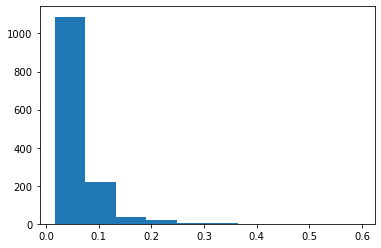

In [125]:
n, bins, patches = plt.hist(spec_df.duration_s)

In [126]:
spec_df = spec_df.loc[spec_df.duration_s<0.15,:]
spec_df.shape

(1322, 17)

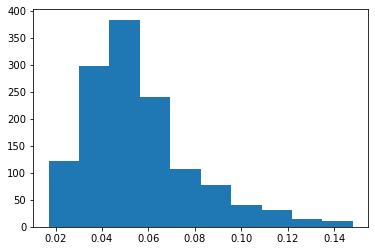

In [127]:
n, bins, patches = plt.hist(spec_df.duration_s)

# UMAP

In [167]:
specs = spec_df.denoised_spectrograms.values

In [168]:
specs = [preprocess_spec(spec) for spec in specs]

In [169]:
def pad_spectro(spec,maxlen):
    padding = maxlen - spec.shape[1]
    z = np.zeros((spec.shape[0],padding))
    padded_spec=np.append(spec, z, axis=1)
    return padded_spec

In [170]:
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr
data.shape

(1322, 1200)

In [171]:
reducer = umap.UMAP(low_memory=True,
                    n_components = 3, 
                    min_dist=0,
                    random_state=2204) 

In [172]:
embedding = reducer.fit_transform(data)

## UMAP with precomputed distance matrix

# Save results

In [173]:
# Save results

for i in range(embedding.shape[1]):
    spec_df["UMAP"+str(i+1)] = embedding[:,i]

/Users/marathomas/opt/anaconda3/envs/coati_feeding_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Visualization

In [34]:
import seaborn as sns
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec


distinct_colors_20 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
                       '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
                       '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
                       '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
                       '#ffffff', '#000000']  
FIGURES = "figures/"

In [29]:
def mara_3Dplot(x,y,z,scat_labels, mycolors,outname):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    labeltypes = sorted(list(set(scat_labels)))
    customPalette = sns.color_palette(mycolors, n_colors=len(labeltypes))

    color_dict = dict(zip(labeltypes, customPalette))
    c = [color_dict[val] for val in scat_labels]

    Axes3D.scatter(ax,
                xs = x,
                ys = y,
                zs = z,
                zdir='z',
                s=20,
                label = c,
                c=c,
                depthshade=False)

    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_zlabel('UMAP3')

    scatters = []
    for label in labeltypes:
        scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

    ax.legend(scatters, labeltypes, numpoints = 1)
    plt.savefig(FIGURES+outname)

# Example use:
#mara_3Dplot(df['UMAP1'], df['UMAP2'], df['UMAP3'],df.label, "Set2", "myplot.jpg")

def plotly_viz(x,y,z,scat_labels, mycolors):
    labeltypes = sorted(list(set(scat_labels)))
    pal = sns.color_palette(mycolors, n_colors=len(labeltypes))
    color_dict = dict(zip(labeltypes, pal))
    c = [color_dict[val] for val in scat_labels]

    fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                    mode='markers',
                                    hovertext = scat_labels,
                                    marker=dict(
                                        size=4,
                                        color=c,                # set color to an array/list of desired values
                                        opacity=0.8
                                        ))])

    fig.update_layout(scene = dict(
                      xaxis_title='UMAP1',
                      yaxis_title='UMAP2',
                      zaxis_title='UMAP3'),
                      width=700,
                      margin=dict(r=20, b=10, l=10, t=10))

    return fig

# Example use:
#plotly_viz(df['UMAP1'], df['UMAP2'], df['UMAP3'],df.label, "Set2")

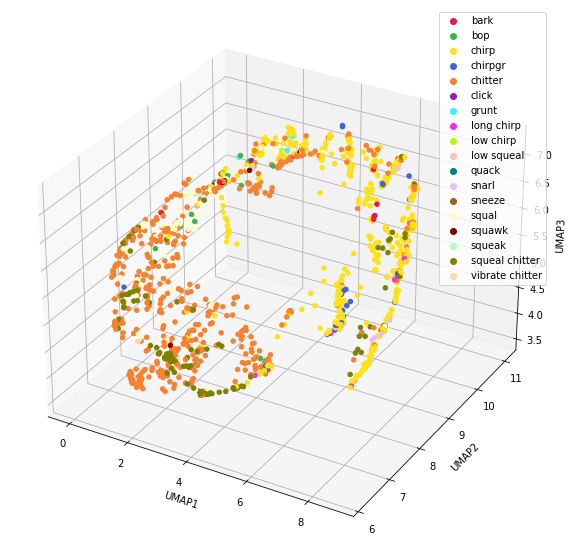

In [174]:
mara_3Dplot(embedding[:,0],
            embedding[:,1],
            embedding[:,2],
            spec_df.label,
            distinct_colors_20,
            datetime.datetime.today().strftime('%Y-%m-%d')+'_UMAP_downsample_plot.jpg')

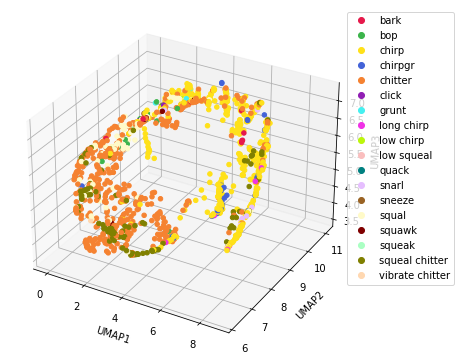

In [175]:
x=embedding[:,0]
y=embedding[:,1]
z=embedding[:,2]
scat_labels = spec_df.label
mycolors = distinct_colors_20
outname = datetime.datetime.today().strftime('%Y-%m-%d')+'_UMAP_plot.jpg'

#fig = plt.figure(figsize=(10,10))
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')

labeltypes = sorted(list(set(scat_labels)))
customPalette = sns.color_palette(mycolors, n_colors=len(labeltypes))

color_dict = dict(zip(labeltypes, customPalette))
c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
              xs = x,
              ys = y,
              zs = z,
              zdir='z',
              s=20,
              label = c,
              c=c,
              depthshade=False)


ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

scatters = []
for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

# get the current axis
ax = plt.gca()
# Shink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(scatters, labeltypes, numpoints = 1, bbox_to_anchor=(1.3, 1))
plt.savefig(FIGURES+outname, bbox_inches='tight')

In [176]:
def update(i, fig, ax):
    ax.view_init(elev=20., azim=i)
    return fig, ax
 
#anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), repeat=True, fargs=(fig, ax))
anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 6), repeat=True, fargs=(fig, ax))

# Save animation
anim.save(FIGURES+'coati_feeding_reduced.gif', dpi=80, writer='pillow', fps=4)
#anim.save(FIGURES+'coati_reduced.gif', dpi=40, writer='pillow', fps=4)

# Play animation
# this is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

In [177]:
plotly_viz(embedding[:,0],
           embedding[:,1],
           embedding[:,2],
           spec_df.label,
           distinct_colors_20)

In [178]:
spec_df['preprocessed_specs'] = [preprocess_spec(spec) for spec in specs]

/Users/marathomas/opt/anaconda3/envs/coati_feeding_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [181]:
spec_df.to_pickle('spec_df.pkl')

In [ ]:
df_subset = spec_df.sample(25, replace=True, random_state=1)

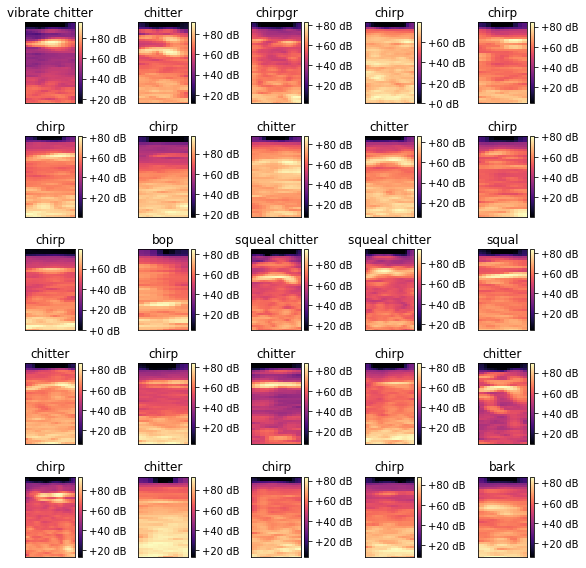

In [159]:
specs = df_subset.denoised_spectrograms.values
specs = df_subset.spectrograms.values
titles = df_subset.label.values

plt.figure(figsize=(8, 8))
for i,spec in enumerate(specs,1):
    plt.subplot(5, 5, i)
    librosa.display.specshow(spec)
    plt.colorbar(format='%+2.0f dB')
    plt.title(titles[i-1])
plt.tight_layout()

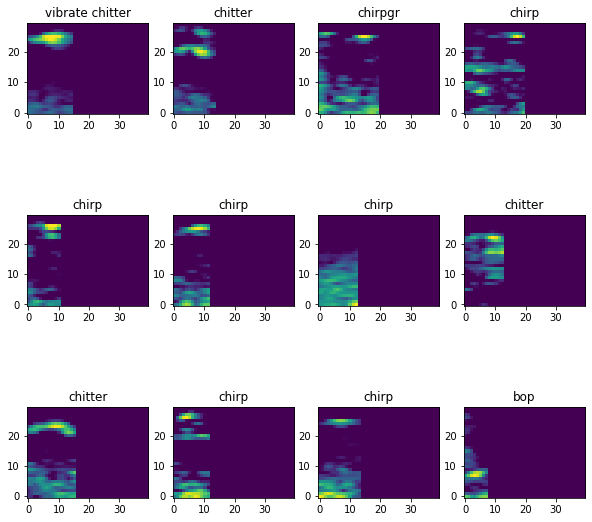

In [166]:
i=0
fig = plt.figure(figsize=(10,10))
for i in range(12):
    spec = preprocess_spec(specs[i])
    spectitle = titles[i]
    padded_spec = pad_spectro(spec, maxlen)
    plt.subplot(3,4,i+1)
    plt.imshow(padded_spec, interpolation='nearest', origin='lower', aspect='equal')
    plt.title(spectitle)

In [153]:
librosa.mel_frequencies(n_mels=40, fmin=0.0, fmax=FMAX, htk=False)

array([    0.        ,   104.65819224,   209.31638447,   313.97457671,
         418.63276894,   523.29096118,   627.94915342,   732.60734565,
         837.26553789,   941.92373012,  1049.21141573,  1168.79160686,
        1302.00053085,  1450.39147474,  1615.694756  ,  1799.83789895,
        2004.96811077,  2233.477319  ,  2488.03006278,  2771.59456271,
        3087.47733196,  3439.36173191,  3831.35092214,  4268.01570548,
        4754.44782596,  5296.31934126,  5899.94876196,  6572.37472873,
        7321.43808661,  8155.87331345,  9085.41036859, 10120.88814935,
       11274.38087835, 12559.3388954 , 13990.74549561, 15585.29164258,
       17361.57059398, 19340.29470877, 21544.5369644 , 24000.        ])

In [144]:
from IPython.display import Audio

In [161]:
i=3
example = list(df_subset.callID)[i]
print(titles[i])
audio = list(labelfile.loc[labelfile.callID==example,'raw_audio'])[0]
sr = SR
Audio(data = audio, rate=sr)

chirp


In [180]:
spec_df.shape

(1322, 21)